# Clustering the Wikipedia corpus using Spark and *k*-means

## Outline
 * Use Apache Spark to extract the 10,000 most frequent words in 1% of English Wikipedia.
 * Cluster these words into 100 groups using their GloVe100 representation.
 * As clustering program, use KMeans from sklearn.

## Spark and Pyspark documentation

General documention is available online when you need to look up the parameters of a function:
 
 * [Pyspark RDD](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html)
 * [Pyspark SQL](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html)
 * [Spark](https://spark.apache.org/docs/2.4.0/)

## Dependencies and data

Import these packages

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
#GLOVE_6B_100D_PATH = 'glove.6B.100d.txt'
ENWIKI_1P_PATH = 'enwiki_1p'
GLOVE_15K_TEST_PATH = 'glove100d_15k.txt'

## Start PySpark

In [3]:
from pyspark import SparkContext   # The main context
from pyspark.sql import SQLContext # The SQL CONTEXT

This utility function will resolve a correct path for Spark

In [4]:
def pyspark_path(filepath):
    return "file:%s" % os.path.abspath(filepath)

We will now create a ```SparkContext``` for testing purposes i.e. run it locally and use all available cores.

```local[*]```, the ```*``` defines the number of cores to use (* = all, 1 = one core, 4 = four cores, etc.).

This will create the Py4j bridge, and start a background JVM which runs the Spark Engine.

In [5]:
sc = SparkContext(master="local[*]", appName="clustering")

The ```sc``` variable will provide a link to the driver webpage where status information can be found, along with all settings and more.

In [6]:
sc

<SparkContext master=local[*] appName=clustering>

### Usage Example
Create some dummy data, 100 000 elements from 0 to 99 999, use 8 partitions.

In [7]:
dataset = sc.parallelize(list(range(100000)), 8)

In [8]:
dataset.take(5)

[0, 1, 2, 3, 4]

In [9]:
from operator import add
dataset.reduce(add)

4999950000

In [10]:
dataset.map(lambda x: x + 15).take(5)

[15, 16, 17, 18, 19]

Find all odd numbers between 10 000 and 50 000 (inclusive), add 134, find all divisible by 17, [collect](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.collect) and [count](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.count) them.

In [11]:
print(dataset.filter(lambda x: x >= 10000 and x <= 50000) \
             .map(lambda x: x + 134)                      \
             .filter(lambda x: x % 17 == 0)               \
             .collect()
             [:10])
dataset.filter(lambda x: x >= 10000 and x <= 50000)       \
             .map(lambda x: x + 134)                      \
             .filter(lambda x: x % 17 == 0)               \
             .count()

[10149, 10166, 10183, 10200, 10217, 10234, 10251, 10268, 10285, 10302]


2353

## Sharing read-only data between executors

It is not uncommon to need some data to be shared between executors.

Common use cases are:
 * Sets/Dictionaries for fast in-memory lookup
 * User-defined objects which contains parameters for the algorithm that should be parallelized
 * General in-memory objects which are used frequently but never modified. These objects might have expensive intialization (such as loading a model, etc.)

Data is shared using a mechanism called *[Broadcasts](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.Broadcast)*, these are serialized objects which are distributed efficiently and shared across muliple calls within a pipeline.

```pickle```is used to serialize objects to transmit over network or locally to executor processes.

In [20]:
lookup = sc.broadcast({"a": "x", "b":"y", "c": "z"})

In [21]:
sc.parallelize(["abc", "def"],1).map(lambda x: "".join([lookup.value.get(ch,ch) for ch in x])).collect()

['xyz', 'def']

In [22]:
setlookup = sc.broadcast(set(["def"]))
sc.parallelize(["abc", "def"],1).filter(lambda x: x in setlookup.value).collect()

['def']

## 1% of Wikipedia Data

We will be using a 1% sample of all paragraphs in English Wikipedia from October 2018.

The data has been segmented in advance, the following specifics apply:
 
 * Tokens/Words are seperated by space ' '
 * Sentences are seperated by tab characters, '\t'
 * Paragraphs are seperated by newlines, which means that each entry is a full paragraph.

In [12]:
paragraphs = sc.textFile(pyspark_path(ENWIKI_1P_PATH))

Display 5 paragraphs.

In [13]:
paragraphs.take(5)

["Nationality words link to articles with information on the nation 's poetry or literature ( for instance , Irish or France ) .",
 'Note : GP = Games played ; Min = Minutes ; SV = Saves ; GA = Goals against ; GAA = Goals against average ; W = Wins ; L = Losses',
 'Antonio Rucco ( born July 5 , 1931 ) is an Italian sprint canoer who competed in the early 1960 s .\tHe finished ninth the K -2 100 0 m event at the 1960 Summer Olympics in Rome .',
 'He started to play at the youth category of Portugal in 1960 , being considered the best player at the Youth Rink Hockey European Championship .\tHe soon was called for the main team , winning the Rink Hockey European Championship , in 1961 , and the Rink Hockey World Championship , the following year .\tDuring his long career , Livramento was capped 209 times , scoring 425 goals , from 1961 to 1977 .\tThe sad incident with a Spanish player at the 1977 Rink Hockey Championship final , led him to leave the national team .',
 'This is a list of U

Count the number of paragraphs

In [14]:
paragraphs.count()

355520

## Preprocessing

The objective of this part is to count words by doing the following parts:
    
 * Convert paragraphs into tokens
 * Normalize tokens into lowercase
 * Count per token
 * Sort and retrieve the top 10000 words in the provided dataset

Split paragraphs into tokens using [flatMap](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.flatMap), map to lowercase, display first 10 tokens.

In [15]:
from pyspark.sql.functions import lower
lowers = paragraphs.flatMap(lambda x: x.split(" ")).map(str.lower)
lowers.take(10)

['nationality',
 'words',
 'link',
 'to',
 'articles',
 'with',
 'information',
 'on',
 'the',
 'nation']

In [17]:
lowers.count()

23710137

Take the top 10 000 most frequent tokens using [takeOrdered](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.takeOrdered).

In [18]:
lowers.map(lambda s: (s, 1)).reduceByKey(add).takeOrdered(10, key=lambda x: -x[1])

[('the', 1387858),
 (',', 1210718),
 ('of', 708672),
 ('and', 606301),
 ('in', 568321),
 ('a', 433758),
 ('to', 433342),
 ('.', 357709),
 ('was', 261767),
 ('-', 214916)]

In [19]:
top10000 = lowers.map(lambda s: (s, 1)).reduceByKey(add).takeOrdered(10000, key=lambda x: -x[1])
len(top10000)

10000

## Process Glove, and extract the embeddings for the top 10000 words

The objective of this part is:

 * Parse the Glove 6B embedding (using the shortened 15000/400000 version here).
 * Filter out only the embeddings matching words that exists in the top 10 000 words.
 * Produce the X which we will cluster

Parse the embedding by using a function which loads embeddings into a dictionary.  
The keys are the words and the values are the corresponding embedding vectors.

In [20]:
def load_glove(filepth):
    embeddings = {}
    n = 0
    with open(filepth) as glove:
        for line in glove:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
            n += 1
            if n % 10000 == 0:
                print('Parsed line %d...' % n)
    #embeddings_dict = embeddings
    #embedded_words = sorted(list(embeddings_dict.keys()))
    return embeddings

In [21]:
embeddings_dict = load_glove(GLOVE_15K_TEST_PATH)

Parsed line 10000...


In [22]:
embeddings_dict['help']

array([-0.2272   ,  0.41578  ,  0.035985 , -0.22895  ,  0.13481  ,
       -0.12407  , -0.56653  , -0.32096  ,  0.16223  , -0.024273 ,
       -0.033683 , -0.4281   , -0.043623 , -0.18682  , -0.29002  ,
       -0.2464   ,  0.51505  , -0.27678  , -0.97691  ,  0.6466   ,
       -0.2955   , -0.34955  ,  0.0085932,  0.17147  , -0.24341  ,
        0.018099 , -0.57991  , -0.68634  ,  0.29723  , -0.19539  ,
       -0.39285  ,  0.55418  , -0.11855  ,  0.40271  , -0.24441  ,
        0.13792  ,  0.14396  ,  0.15116  ,  0.19257  , -0.095074 ,
       -0.59663  , -0.27685  , -0.43814  , -0.98947  , -0.52515  ,
        0.52006  , -0.4445   , -0.23366  , -0.21019  , -0.9059   ,
       -0.78404  ,  0.11093  ,  0.09208  ,  1.2145   ,  0.52067  ,
       -2.4821   , -0.17693  , -0.94136  ,  1.8578   ,  0.17312  ,
       -0.32761  ,  0.45067  , -0.092353 ,  0.11201  ,  0.50869  ,
        0.52743  , -0.075203 ,  0.73518  ,  0.40716  , -0.74727  ,
        0.60342  , -0.69189  , -0.56087  , -0.87252  ,  0.5694

Match embeddings with words in Wikipedia corpus.

In [23]:
top10000_set = sc.broadcast(set([word for word, cnt in top10000]))

In [24]:
emb_pairs = sc.parallelize(list(embeddings_dict.items()))

In [25]:
top10000_dict = emb_pairs.filter(lambda tup: tup[0] in top10000_set.value).collectAsMap()

In [26]:
len(top10000_dict)

9336

So not all 10 000 words exists in GloVe.

Produce the X that we will cluster. Transform list into a list of embeddings and create a numpy array from it.

In [28]:
wordlist_mostcommon = [tup[0] for tup in top10000 if tup[0] in top10000_dict]
len(wordlist_mostcommon)
wordlist_mostcommon[:10]

['the', ',', 'of', 'and', 'in', 'a', 'to', '.', 'was', '-']

In [30]:
X = np.array([top10000_dict[word] for word in wordlist_mostcommon], dtype=np.double)

In [31]:
X[5,:]

array([-0.27085999,  0.044006  , -0.02026   , -0.17395   ,  0.6444    ,
        0.71213001,  0.35510001,  0.47138   , -0.29637   ,  0.54426998,
       -0.72294003, -0.0047612 ,  0.040611  ,  0.043236  ,  0.29729   ,
        0.10725   ,  0.40156001, -0.53662002,  0.033382  ,  0.067396  ,
        0.64556003, -0.085523  ,  0.14103   ,  0.094539  ,  0.74947   ,
       -0.19400001, -0.68739003, -0.41740999, -0.22807001,  0.12      ,
       -0.48999   ,  0.80944997,  0.045138  , -0.11898   ,  0.20161   ,
        0.39276001, -0.20121001,  0.31354001,  0.75304002,  0.25907001,
       -0.11566   , -0.029319  ,  0.93498999, -0.36067   ,  0.52420002,
        0.23706   ,  0.52714998,  0.22869   , -0.51958001, -0.79348999,
       -0.20367999, -0.50186998,  0.18748   ,  0.94282001, -0.44834   ,
       -3.67919993,  0.044183  , -0.26751   ,  2.19970012,  0.241     ,
       -0.033425  ,  0.69553   , -0.64472002, -0.0072277 ,  0.89574999,
        0.20015   ,  0.46493   ,  0.61932999, -0.1066    ,  0.08

## Cluster X using KMeans and visualize the results

 * Cluster these embeddings into 100 clusters using [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) from scikit-learn
 * Visualize the results

In [32]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [33]:
kmeans = KMeans(n_clusters=100, n_jobs=-1, random_state=2018)

In [34]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=2018, tol=0.0001, verbose=0)

The code below computes the score which follows this equation:

\begin{equation*}
-\sum_{i=1}^n (\sum_{k=1}^{100} (x_{i,k} - {xc}_{i,k})^2)
\end{equation*}

Where $x$ is the embedding, $xc$ is the assigned cluster center.

*In words:* It is the negative sum of squared differences per dimension (100d).

In [35]:
kmeans.score(X)

-151488.6011100474

Predict clusters, the output will be indicies. Documentation of [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

In [36]:
X_clusters = kmeans.predict(X)

In [37]:
X_clusters.shape

(9336,)

In [38]:
X_clusters[0:10]

array([57, 57, 57, 57, 57, 57, 33, 57, 57, 57], dtype=int32)

Create mapping from word to cluster

In [39]:
len(wordlist_mostcommon)

9336

Create mapping from cluster to all words in cluster
Plan:
  1. `zip` words and clusters.
  2. Flip pairs while wrapping words in lists, then reduce by key with the list concatenation function.

Small example:

In [44]:
x = list(zip(['a', 'b','c'], [1,2,3]))
x

[('a', 1), ('b', 2), ('c', 3)]

In [45]:
from operator import concat
wc_test = sc.parallelize( [('aa', 1), ('bb', 2), ('cc', 1), ('dd', 3), ('ee', 3)] )
wc_test.map(lambda x_y: (x_y[1], [x_y[0]])).reduceByKey(concat).collect()

[(1, ['aa', 'cc']), (2, ['bb']), (3, ['dd', 'ee'])]

Now do it for the real data.

In [46]:
# Wrap words in lists.
# Otherwise words will just be concatenaed as a really long string and not as a list.
wc_pairs = sc.parallelize(list(zip(wordlist_mostcommon, X_clusters)))
cluster_wordlists = wc_pairs.map(lambda w_c: (w_c[1], [w_c[0]]) ).reduceByKey(concat)

Create a list of all cluster sizes, i.e. the number of words in each cluster

In [47]:
cluster_size = cluster_wordlists                               \
                   .map(lambda c_wl: (c_wl[0], len(c_wl[1])) ) \
                   .sortByKey().values().collect()

Plot the histogram

(array([11., 13., 11., 19., 17., 11.,  7.,  4.,  3.,  4.]),
 array([ 41. ,  54.1,  67.2,  80.3,  93.4, 106.5, 119.6, 132.7, 145.8,
        158.9, 172. ]),
 <a list of 10 Patch objects>)

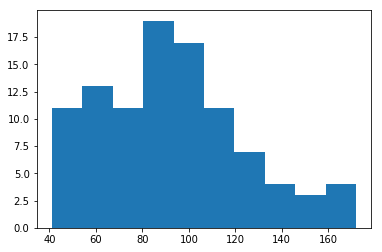

In [50]:
plt.hist(np.array(cluster_size))

Look at the words in the smallest and largest cluster, does one see any structure?

In [51]:
# Quick consistency check.
cluster_wordlists.map(lambda c_wl: (c_wl[0], len(c_wl[1])) ).values().sum()

9336

In [52]:
# Print (cluster, size) list sorted (ascending) by size.
size_list = cluster_wordlists.map(lambda c_wl: (c_wl[0], len(c_wl[1])) ).sortBy(lambda pair: pair[1]).collect()
print(size_list[1:5], '... cut ...\n', size_list[-5:])

[(60, 42), (39, 43), (52, 44), (47, 46)] ... cut ...
 [(33, 154), (59, 160), (99, 163), (57, 170), (29, 172)]


In [54]:
wc_pairs_dict = wc_pairs.collectAsMap() 
wordlist_dict = cluster_wordlists.collectAsMap()
print(wordlist_dict[size_list[1][0]], '\n')
print(wordlist_dict[size_list[-1][0]][:16], '...')

['seven', 'eight', 'uk', 'ten', 'nine', 'chart', 'consists', 'remaining', 'twenty', 'billboard', 'consisted', 'covers', 'hundred', 'twelve', 'sub', 'consisting', 'charts', 'thirty', 'eleven', 'peaked', 'lasted', 'ranks', 'fifteen', 'forty', 'fifty', 'sixteen', 'tenth', 'thirteen', 'numbered', 'comprises', 'fourteen', 'topped', 'comprising', 'dozen', 'eighteen', 'sixty', 'comprised', 'charted', 'seventeen', 'peaking', 'spanning', 'spans'] 

['i', 'what', 'just', 'you', 'do', 'we', 'good', 'never', 'see', 'how', 'little', 'love', 'does', 'my', 'real', 'ever'] ...


Test with a get nearby words function.

In [55]:
def get_nearby(word):
    """Returns: list of words having the same cluster as 'word'."""
    return wordlist_dict[wc_pairs_dict[word]]

In [56]:
get_nearby("sweden")

['france',
 'canada',
 'germany',
 'republic',
 'italy',
 'spain',
 'russia',
 'britain',
 'poland',
 'sweden',
 'netherlands',
 'norway',
 'turkey',
 'austria',
 'switzerland',
 'czech',
 'greece',
 'denmark',
 'belgium',
 'hungary',
 'portugal',
 'ukraine',
 'finland',
 'romania',
 'serbia',
 'azerbaijan',
 'croatia',
 'bulgaria',
 'bosnia',
 'yugoslavia',
 'albania',
 'malta',
 'slovenia',
 'cyprus',
 'iceland',
 'lithuania',
 'ussr',
 'armenia',
 'macedonia',
 'herzegovina',
 'baltic',
 'kosovo',
 'slovakia',
 'luxembourg',
 'estonia',
 'kazakhstan',
 'latvia',
 'czechoslovakia',
 'montenegro',
 'belarus']

In [57]:
words = ["king", "sweden", "obama", "home", "learning"]
clusters = [get_nearby(word) for word in words]
cluster_colors = ["red", "green", "blue", "purple", "teal"] # HTML colors are allowed inside here.

Flatten words and clusters

In [58]:
all_words = [word for cluster in clusters for word in cluster]
all_cluster_color = [
    cluster_color for cluster_color_array in 
    (
        [color] * len(cluster)
        for cluster, color in 
        zip(clusters, cluster_colors)
    )
    for cluster_color
    in cluster_color_array
]

Use ```all_words``` and translate into a numpy array called ```X_words``` of all embeddings.

In [59]:
X_words = np.array([top10000_dict[word] for word in all_words], dtype=np.double)

In [60]:
X_words.shape

(501, 100)

[**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) is a dimensionality reduction algorithm useful for projecting high dimensional data into a low dimensional space such as 2D, which we can plot and more easily understand spatially.

In [61]:
tsne = TSNE(n_components=2, random_state=2018)

In [62]:
X_pos = tsne.fit_transform(X_words)

The code below makes a large plot using Matplotlib and attaches labels to all points. It provided for reference and a fallback if the more advanced visualization fails.

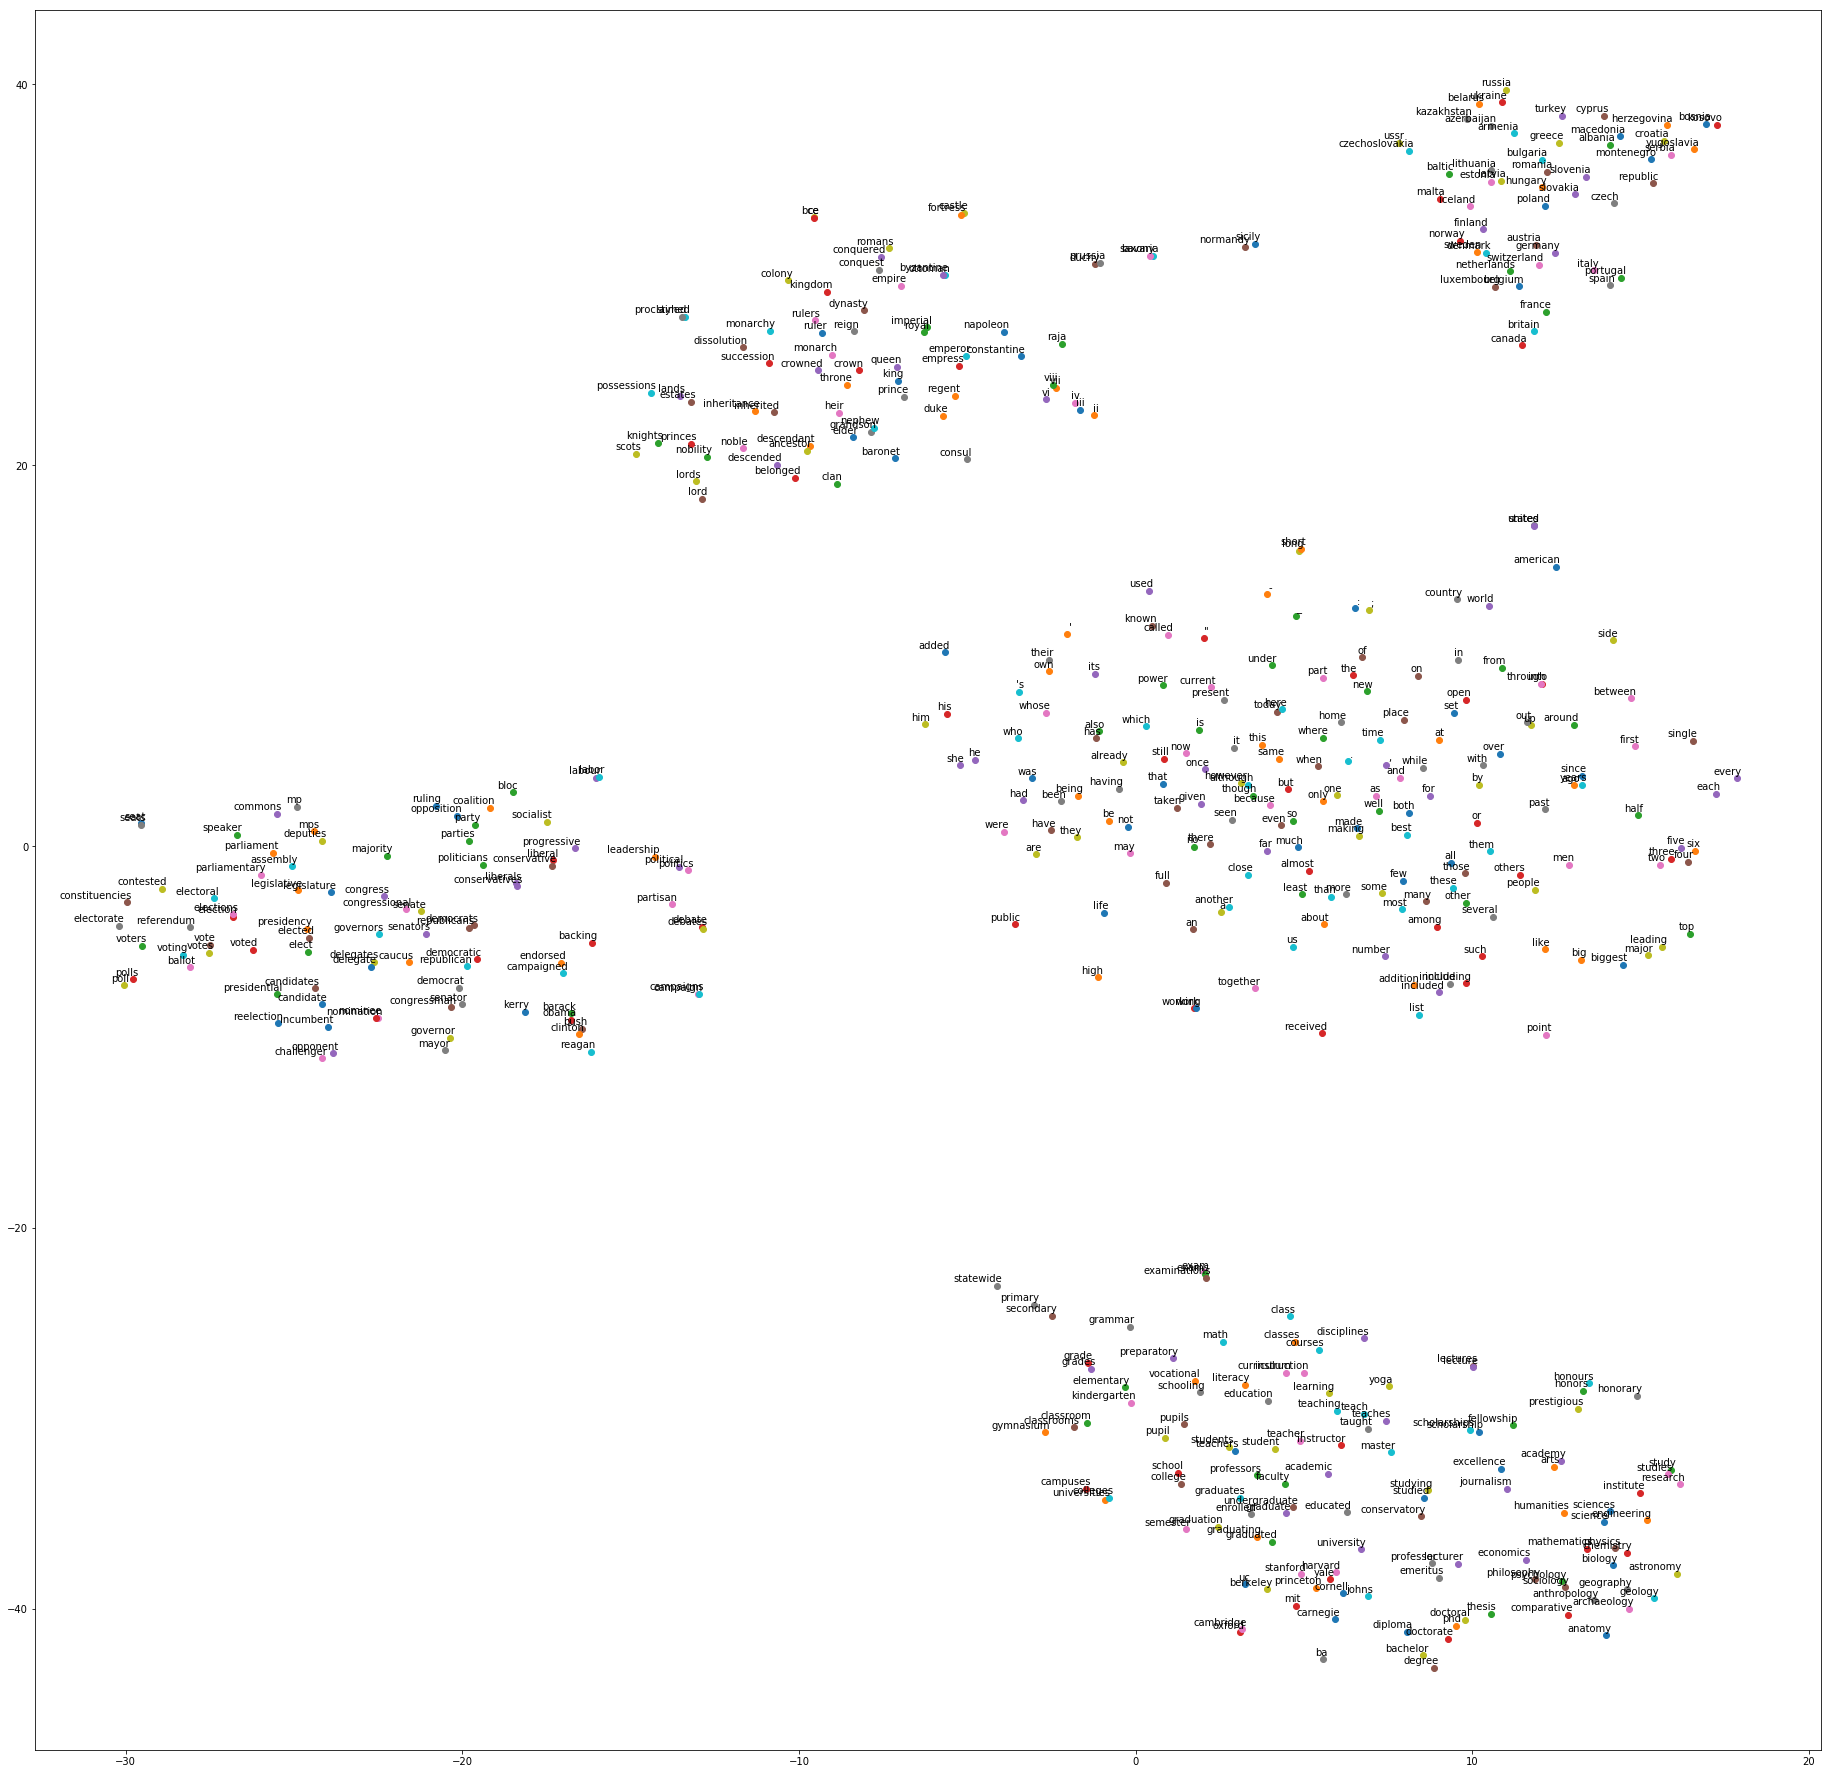

In [63]:
# Visualize using matplotlib and produce an image of the points and words
labels = all_words
x = []
y = []
for x_val,y_val in X_pos:
    x.append(x_val)
    y.append(y_val)

plt.figure(figsize=(32, 32)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

### Interactive Visualization with D3.js
The cells below will produce a HTML file that has the previously plotted image embedded as JSON.

The code below is provided for visualization purposes: to understand it is not a requirement.

The standard output is ```visualize.html``` in the current folder.

In [64]:
import json

# Scale to fit box of dimensions below
WIDTH = 768.0
HEIGHT = 768.0
OUTPUT_FILE = "visualize.html"

# Run this cell to set the template
HTML_TEMPLATE = """
<!DOCTYPE html>
<head>
  <style>

      html {
        font-family: "Helvetica Neue", Helvetica, arial, sans-serif;
        font-size: 16px;
      }

      body {
        margin: 0;
        padding: 0;
        width: 100%;
        width: 100%;
        overflow: hidden;
      }

      svg {
        display: block;
        width: 100%;
        height: auto;
      }

      div#container {
        overflow: hidden;
      }
    </style>
    <meta charset="utf-8">
</head>
<body>
  <div class="container">
<svg width="640" height="480"></svg>
<script src="https://d3js.org/d3.v4.min.js"></script>

<!-- Here is our data -->
<script id="raw-data" language="application/json">
__OUTPUT_JSON__
</script>
<script>

// Parse data from tag inside this doucment
var inputdata = JSON.parse(document.getElementById('raw-data').innerHTML);

var svg = d3.select("svg"),
    width = +svg.attr("width"),
    height = +svg.attr("height");

// Create a dummy array with indicies
var indicies = d3.range(inputdata.length);

// Produce points with some zoom magic
var circle = svg.selectAll("circle")
  .data(indicies)
  .enter()
  .append("circle")
    .attr("r", 2.5)
    .attr("fill", function(d) {return inputdata[d]["color"]})
    .attr("transform", transform(d3.zoomIdentity));

// Produce labels attached/placed relative to points
var lbls = svg.selectAll("texts")
                .data(indicies)
                .enter()
                .append("text")
                .text(function(d) {
                  return inputdata[d]["label"];
                })
                .attr("font-size", "15px")
                .attr("fill", function(d) {return inputdata[d]["color"]})
                .attr("transform", transform(d3.zoomIdentity));

// Will recieve index, and produce transform directive for that index
function transform(t) {
  return function(d) {
    return "translate(" + t.apply(inputdata[d]["position"]) + ")";
  };
}

// Zoom transformation function
function zoom() {
  circle.attr("transform", transform(d3.event.transform));
  lbls.attr("transform", transform(d3.event.transform));
}

// Add the zoom handler, that listens to events.
svg.append("rect")
    .attr("fill", "none")
    .attr("pointer-events", "all")
    .attr("width", "100%")
    .attr("height", "100%")
    .call(d3.zoom()
        .scaleExtent([1, 16]) //The minimum and maximum scale factor 
        .on("zoom", zoom));

</script>
</div>
</body>
</html>
"""

In [65]:
# Find extents
x_extents = [min(pos[0] for pos in X_pos), max(pos[0] for pos in X_pos)]
y_extents = [min(pos[1] for pos in X_pos), max(pos[1] for pos in X_pos)]

# Compute translation
translation = [-x_extents[0], -y_extents[0]]

# Compute scaling, flip y to match convention that y is down not up.
scale = [WIDTH/(x_extents[1]-x_extents[0]), -HEIGHT/(y_extents[1]-y_extents[0])]

# Produce JSON dictionary
output = []
labels = all_words
for (x_val, y_val), label, color in zip(X_pos, labels, all_cluster_color):
    output.append({"position": ((float(x_val)+translation[0])*scale[0], (float(y_val)+translation[1])*scale[1]+HEIGHT), "label": label, "color": color})

# Write HTML file with JSON embedded
with open(OUTPUT_FILE, "w") as fout:
    fout.write(HTML_TEMPLATE.replace("__OUTPUT_JSON__", json.dumps(output)))

Open the HTML file in your favorite browser.

How to use:
 * Drag to move the image around.
 * Zoom using the mousewheel, default min and max zoom values have been set.

**Note:** *Internet access is required* for the page to work. The page downloads d3.js during start-up from https://d3js.org/d3.v4.min.js